# ADC Calibration

In [1]:
import serial
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import pyvisa as visa
from pathlib import Path
from scipy.interpolate import interp1d

from save_cal_data import save_measurement, load_measurement
from progressbar import update_progress
from user_prompts import yes_or_no

In [2]:
def serialQry(port, command):
    port.reset_input_buffer()
    port.write((command + '\n').encode('ascii'))
    return port.readline().decode('ascii').strip() #strip removes white space

def serialCmd(port, command):
    port.reset_input_buffer()
    port.write((command + '\n').encode('ascii'))

In [3]:
def rms(x):
    return np.sqrt(np.mean(x**2))

In [4]:
sr542 = serial.Serial(port='COM11', baudrate=115200, timeout=.5)
dc205 = serial.Serial(port='COM12', baudrate=115200, timeout=0.5)
cs580 = serial.Serial(port='COM10', baudrate=9600, timeout=0.5)
rm = visa.ResourceManager()
rm.list_resources()
dvm = rm.open_resource('USB0::0x0957::0xB318::MY52449038::INSTR')

In [5]:
print(serialQry(sr542, '*IDN?'))
print(serialQry(dc205, '*IDN?'))
print(dvm.query('*IDN?'))

Stanford_Research_Systems, SR542, s/n00001007, v0.10
Stanford_Research_Systems,DC205,s/n20500218,ver1.80
Agilent Technologies,34450A,MY52449038,00.56-00.63



# Define Cal Functions

In [6]:
def twos_comp(val, bits):
    if (val & (1 << (bits - 1))) != 0: # sign bit is set
        val = val - (1 << bits)
    return val

In [7]:
# Sweep Functions for AdcChannel.MeasCodeVs
def CurrU(setpoint):
    if setpoint in np.arange(0, 4096, 1):
        serialCmd(sr542, f'$SUV {setpoint:d}, 2048')
    else:
        raise ValueError('invalid setpoint')

def dc205_set_voltage(setpoint):
    serialCmd(dc205, f'VOLT {setpoint:.3f}')      

In [8]:
class Resistor():
    def __init__(self, Rnom_ohms, tol_perc):
        self.R_ohms = Rnom_ohms
        self.Rnom_ohms = Rnom_ohms
        self.tol_perc = tol_perc
        
    def SweepIMeasV(self, I_init_A, I_final_A, I_step_A):        
        I_sweep = np.arange(I_init_A, I_final_A + I_step_A, I_step_A)

        serialCmd(cs580, 'GAIN G50mA')
        serialCmd(cs580, f'CURR {I_init_A:.3f}')
        serialCmd(cs580, 'INPT OFF')
        serialCmd(cs580, 'SOUT ON')

        time.sleep(1.0)
        V_meas = []

        for curr in I_sweep:
            serialCmd(cs580, f'CURR {curr:.3f}')
            time.sleep(1.0)
            V_meas.append(float(dvm.query('MEAS:VOLT:DC? 0.1, 3e-5').strip('\n')))
            
            update_progress(len(V_meas) / len(I_sweep))

        serialCmd(cs580, 'CURR 0')
        serialCmd(cs580, 'SOUT OFF')

        coeffs, cov = np.polyfit(I_sweep, V_meas, 1, cov=True)
        fit = np.poly1d(coeffs)
        R_meas = coeffs[0]
        R_std = np.sqrt(np.diag(cov))[0]
        print(f'R = {R_meas:.5e} +- {R_std:.5e} Ohms')
        
        fig, ax = plt.subplots()
        
        ax.plot(I_sweep, V_meas, '.')
        ax.plot(I_sweep, fit(I_sweep), label=f'fit: R={coeffs[0]:.6} Ohms')
        ax.set_xlabel('applied current (A)')
        ax.set_ylabel('meas voltage (V)')
        ax.legend()   
        ax.set_title('4 pt I-V Resistance Measurement')
        
        # define reasonable measurement bounds: +/- tol%
        if (R_meas > self.Rnom_ohms*(1 + self.tol_perc/100)) or (R_meas < self.Rnom_ohms*(1 - self.tol_perc/100)):
            print('Resistance measurement out-of-spec')
            return
        else:
            self.R_ohms = R_meas

class AdcChannel():
    def __init__(self, channel, adcBits, differential, target_units):        
        # 0 = VCO
        # 1 = CURR_MON
        # 2 = VOLT_MON
        # 4 = CHOP_5V_MON
        
        if channel in [0, 1, 2, 4]:
            self.channel = channel
        else:
            raise ValueError('Invalid Channel Number')                
        self.adcBits = adcBits
        self.differential = differential # True/False
        if self.differential:
            self.maxCode = 2**(self.adcBits - 1) - 1
        else:
            self.maxCode = 2**self.adcBits - 1
        self.numCodes = 2**self.adcBits
        self.Vref = 3.3
        self.LSB_V = self.Vref/self.numCodes # LSB size, in Volts               
        self.calOffset = 0.0
        self.calSlope = 1.0  
        self.passed = False 
        self.cald = False
        offset, slope = self.DownloadCalData()
        self.on_unit_offset = offset
        self.on_unit_slope = slope
        offset, slope = self.GetDefaultCal()
        self.default_offset = offset
        self.default_slope = slope
        self.target_units = target_units 
        # The firmware returns an ADC reading on this channel in units of target_units
        # target_units is a string, like 'A', 'V', 'degC', or 'frac of FS'.

    def VoltsToCode(self, v):        
        return v/self.Vref * self.maxCode                  
        
    def CodeToVolts(self, c):      
        # assumes signed adc code c  
        return c/self.maxCode * self.Vref

    def AdcToFrac(self, c):
        # assumes signed adc code x
        return c/self.maxCode        

    def FracToAdc(self, x):
        return x*self.maxCode 

    def MeasCodeVs(self, sweepMethod, sweepList):
        """ Performs a measurement sweep using an arbitrary function to sweep some setpoint
        through the values in sweepList. 
        The sweepMethod must be defined to accept a single parameter as a setpoint.
        Make sure to activate and de-activate the sweepMethod before and after
        MeasCodeVs() is called.
        """
        codes = []
        v_meas = []
        for s in sweepList:
            sweepMethod(s)

            time.sleep(0.5) #TODO: how long to sleep here?
            c = int(serialQry(sr542, f'$COD? {self.channel}'))
            # TODO: choose range properly
            v = float(dvm.query('MEAS:VOLT:DC? AUTO, 3e-5').strip('\n'))
            if self.differential:
                c = twos_comp(c, self.adcBits)
            codes.append(c) 
            v_meas.append(v)

            update_progress(len(codes) / len(sweepList))

        return np.array(v_meas), np.array(codes)
        
    def CalculateCal(self, input_target_units, measuredCodes, fitRange=None):                     
        
        # TODO: check if measuredCodes are within 5% of 0 or self.maxCode
        # and avoid using this data for the linear fit
        adc_frac = self.AdcToFrac(measuredCodes)
        # if the fitRange is None (not specified), use the entire data set
        if fitRange is None:
            fitRange = np.ones(len(measuredCodes), dtype=bool)
        # otherwise, expect fitRange to be a masking array of booleans

        # Do a linear fit of the form:
        # y = m*x + b
        # where:
        # y = input [in target units]
        # x = adc code
        # m = slope: code-to-target units
        # b = offset: [in target units]        
        coeffs, cov = np.polyfit(measuredCodes[fitRange], input_target_units[fitRange], 1, cov=True)
        fit = np.poly1d(coeffs)
        slope = coeffs[0]
        offset = coeffs[1]

        fig, ax = plt.subplots(2, 1, figsize=(8,8))        
        ax[0].plot(measuredCodes, input_target_units, '.')
        ax[0].plot(measuredCodes, fit(measuredCodes))
        ax[0].set_xlabel('adc code')
        ax[0].set_ylabel(f'input ({self.target_units})')
        
        axTop = ax[0].secondary_xaxis('top', functions=(self.AdcToFrac, self.FracToAdc))
        axTop.set_xlabel('adc code/max code')        
        
        res_c = fit(measuredCodes[fitRange]) - input_target_units[fitRange]
        ax[1].plot(measuredCodes[fitRange], res_c, 'o-')
        ax[1].set_ylabel('fit residual (adc code)')
        ax[1].set_xlabel('measured code (adc code)')
        
        print(f'RMS Residual Error = {rms(res_c):.3e} adc codes')
        
        self.calSlope = slope
        self.calOffset = offset               
        
    def GetCalibratedFrac(self, measuredFrac):
        return measuredFrac*self.calSlope + self.calOffset
        #return (measuredFrac - self.calOffset)/self.calSlope

    def GetCalibratedValue(self, measuredCode):
        return measuredCode*self.calSlope + self.calOffset # [in target units]
    
    def ShowCalibration(self, input_target_units, measuredCodes):                      
        calibrated_values = self.GetCalibratedValue(measuredCodes) 
        uncalibrated_values = measuredCodes*self.default_slope + self.default_offset

        cal_error = input_target_units - calibrated_values       
        uncal_error = input_target_units - uncalibrated_values

        cal_error_codes = cal_error/self.default_slope
        uncal_error_codes = uncal_error/self.default_slope
        
        fig, ax = plt.subplots(2, 1, figsize = (8,8))
        ax[0].plot(input_target_units, uncal_error_codes, 'o-', label='uncal', color='C0')   
        ax[0].plot(input_target_units, cal_error_codes, 'o-', label='cal', color='C1')       
        ax[0].set_ylabel("error (adc code)")
        ax[0].set_title(f'RMS Uncalibrated Error = {rms(uncal_error_codes):.3f} adc codes')
        ax[0].legend()

        ax[1].plot(input_target_units, cal_error_codes, 'o-', label='cal', color='C1')        
        ax[1].set_ylabel('calibrated error (adc code)')
        ax[1].set_xlabel(f'input ({self.target_units})')
        ax[1].set_title(f'RMS Calibrated Error = {rms(cal_error_codes):.3f} adc codes')
        ax[1].legend()        
            
    def EvaluatePassFail(self, dacCodes, V_meas):
        pass

    def DownloadCalData(self):
        offset, slope = serialQry(sr542, f'$ADC? {self.channel}').split(',')
        offset = float(offset)
        slope = float(slope)

        if (offset != 0.0) or (slope != 1.0):
            self.cald = True
        else:
            self.cald = False

        return offset, slope

    def GetDefaultCal(self):
        # 1. Load the default cal
        serialCmd(sr542, '$LDC DEF')
        # 2. Query the cal for this particular channel
        offset, slope = serialQry(sr542, f'$ADC? {self.channel}').split(',')
        offset = float(offset)
        slope = float(slope)
        # 3. Restore the calibration from memory
        serialCmd(sr542, '$LDC MEM')

        return offset, slope

    def UploadCalData(self):
        offset, slope = self.DownloadCalData()
        offset = float(offset)
        slope = float(slope)

        d_offset = (self.calOffset - offset)
        d_slope = (self.calSlope - slope)

        print(f"{'Quantity' : <10}{'Default cal' : <15}{'On-unit cal' : <15}{'New cal' : <15}{'(New - On-unit)' : <15}")
        print(f"{'-'*70}")
        print(f"{'slope' : <10}{self.default_slope : <15.6e}{slope : <15.6e}{self.calSlope : <15.6e}{d_slope : <15.6e}")
        print(f"{'offset' : <10}{self.default_offset : <15.6e}{offset : <15.6e}{self.calOffset : <15.6e}{d_offset : <15.6e}")     

        if (np.abs(d_offset*self.numCodes) > 1 or np.abs(d_slope*self.numCodes) > 1):
            print('This will adjust the calibration of this ADC channel')            
            proceed = yes_or_no('Proceed?')
        else:
            print('The calibration is unchanged')           
            proceed = False 
            
        if proceed:
            serialCmd(sr542, f'$ADC {self.channel}, {self.calOffset:.6e}, {self.calSlope:.6e}')
            
    def SaveCalData(self):
        controller_sn = serialQry(sr542, '*IDN?').split(',')[2].strip(' s/n')
        save_measurement('.\CalData', controller_sn, f'Ch{self.channel}_adcCal', np.vstack([self.calOffset, self.calSlope]), 
                                                                                ['offset', 'slope'], fmt='%.6e')

    def LoadCalData(self):
        controller_sn = serialQry(sr542, '*IDN?').split(',')[2].strip(' s/n')
        data = load_measurement('.\CalData', controller_sn, f'Ch{self.channel}_adcCal')

        if not data.any():
            print('No measurements have been saved for this sn')
        else:
            self.calOffset = data[0]
            self.calSlope = data[1]
        

# Calibrate VCO Input

Connect DC205 to VCO Input

In [9]:
Vco = AdcChannel(0, adcBits = 16, differential=True, target_units='frac of FS')

In [172]:
testVolts = np.linspace(0, 10, 21)
testVolts

array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
        5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. ])

In [200]:
serialCmd(dc205, 'VOLT 0.0')
serialCmd(dc205, 'SOUT ON')
v_dvm, adcCodes = Vco.MeasCodeVs(dc205_set_voltage, testVolts)
serialCmd(dc205, 'VOLT 0.0')
serialCmd(dc205, 'SOUT OFF')

Progress: [####################] 100.0%


RMS Residual Error = 6.765e-05 adc codes


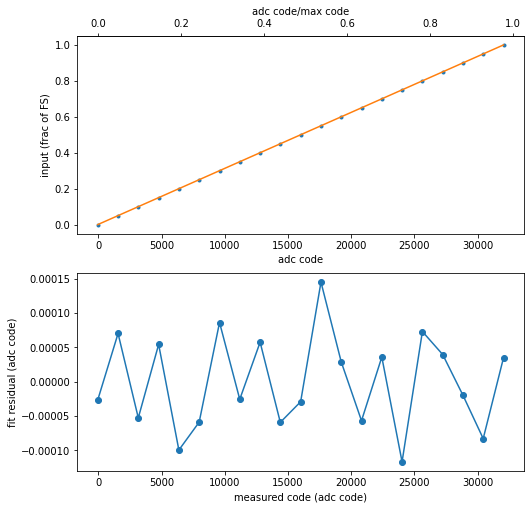

In [201]:
Vco.CalculateCal(v_dvm/10, adcCodes)

In [202]:
print(Vco.calOffset)
print(Vco.calSlope)

0.0017206811100693579
3.1153065885937586e-05


In [203]:
# TODO: Add comparison to default value
Vco.calSlope/Vco.default_slope

1.0207924923575098

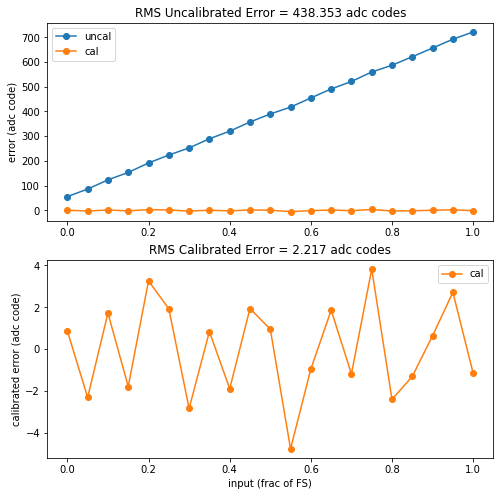

In [215]:
Vco.ShowCalibration(v_dvm/10, adcCodes)

In [205]:
serialQry(sr542, '$ADC? 0')

'1.856212e-03, 3.114335e-05'

In [10]:
# If data have been previously saved, can load from measurement file and then upload to controller
Vco.LoadCalData()

Loading .\CalData\Ch0_adcCal\00001007_Ch0_adcCal_6.csv


In [11]:
Vco.UploadCalData()

Quantity  Default cal    On-unit cal    New cal        (New - On-unit)
----------------------------------------------------------------------
slope     3.051851e-05   3.115307e-05   3.115307e-05   0.000000e+00   
offset    0.000000e+00   1.720681e-03   1.720681e-03   0.000000e+00   
The calibration is unchanged


In [207]:
serialQry(sr542, '$ADC? 0')

'1.720681e-03, 3.115307e-05'

In [208]:
Vco.SaveCalData()

## Verify the calibration

In [209]:
serialCmd(sr542, 'SRCE VCO')

In [224]:
verifyVolts = np.linspace(0.25, 10, 20)
verifyVolts

array([ 0.25      ,  0.76315789,  1.27631579,  1.78947368,  2.30263158,
        2.81578947,  3.32894737,  3.84210526,  4.35526316,  4.86842105,
        5.38157895,  5.89473684,  6.40789474,  6.92105263,  7.43421053,
        7.94736842,  8.46052632,  8.97368421,  9.48684211, 10.        ])

In [225]:
f_src = []
v_dvm = []
serialCmd(dc205, 'SOUT ON')

for v in verifyVolts:
    serialCmd(dc205, f'VOLT {v:.3f}')           

    time.sleep(3.0) #TODO: how long to sleep here?
    f = float(serialQry(sr542, 'MFRQ? SRCE'))
    v = float(dvm.query('MEAS:VOLT:DC? AUTO, 3e-5').strip('\n'))
    f_src.append(f)    
    v_dvm.append(v)

    update_progress(len(f_src) / len(testVolts))

serialCmd(dc205, 'VOLT 0')
serialCmd(dc205, 'SOUT OFF')

Progress: [###################-] 95.2%


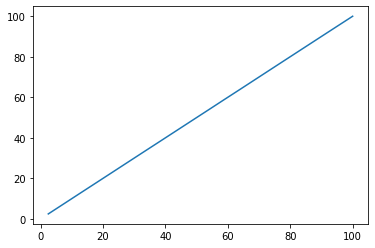

In [227]:
plt.plot(np.array(v_dvm)/10 * 100, f_src)

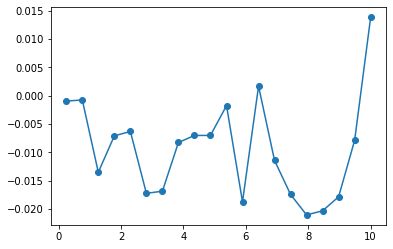

In [228]:
freq_error = np.array(v_dvm)/10 * 100 - f_src
plt.plot(v_dvm, freq_error, 'o-')

In [229]:
rms(freq_error)

0.012755102787994995

# Calibrate CURR_MON

Place CS580 Output at:  
I+ @ R314-2 (TP312)  
I- @ R314-1 (TP311)  

Place DVM voltage probes at:  
V+ @ R314-2 (TP312)  
V- @ R314-1 (TP311)    
(Note that the polarity is reversed because IMonW is fed to an inverting difference amp)

In [230]:
R_W = Resistor(0.1, 10)

Progress: [####################] 100.0%
R = 9.91992e-02 +- 1.37076e-05 Ohms


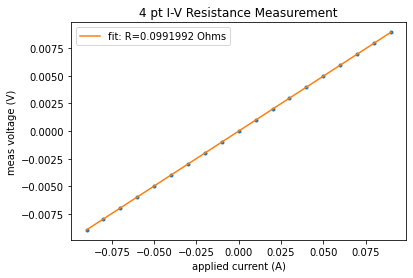

In [231]:
R_W.SweepIMeasV(-90e-3, 90e-3, 10e-3)

In [12]:
CurrMon = AdcChannel(1, adcBits = 16, differential=True, target_units='A')

In [234]:
testCodes = np.linspace(0, 4095, 25, dtype=np.int16)
testCodes

array([   0,  170,  341,  511,  682,  853, 1023, 1194, 1365, 1535, 1706,
       1876, 2047, 2218, 2388, 2559, 2730, 2900, 3071, 3241, 3412, 3583,
       3753, 3924, 4095], dtype=int16)

In [235]:
serialCmd(sr542, '$IEN ON')
v_dvm, c_adc = CurrMon.MeasCodeVs(CurrU, testCodes)
serialCmd(sr542, '$SUV 2048, 2048')
serialCmd(sr542, '$IEN OFF')

Progress: [####################] 100.0%


RMS Residual Error = 1.274e-03 adc codes


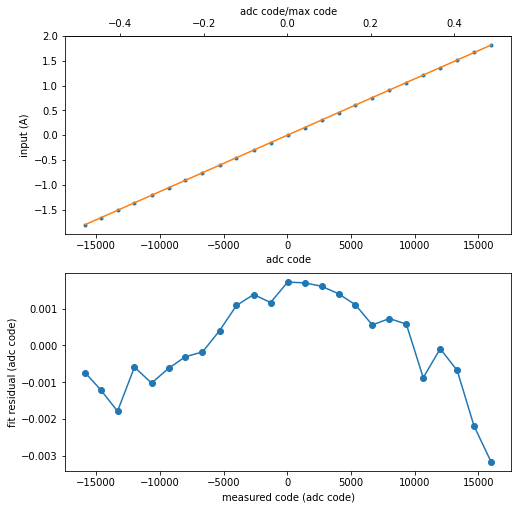

In [236]:
#fitRange = (testCodes > 0.1*4095) & (testCodes < 0.9*4095)
I_W = v_dvm/R_W.R_ohms
CurrMon.CalculateCal(I_W, c_adc)

In [238]:
CurrMon.calSlope/CurrMon.default_slope

1.0005560929867576

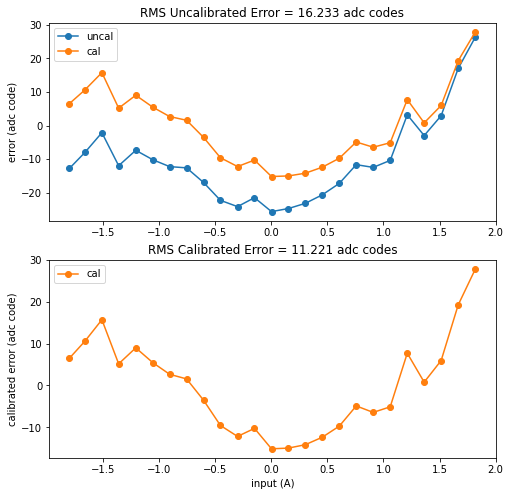

In [239]:
CurrMon.ShowCalibration(I_W, c_adc)

In [13]:
CurrMon.LoadCalData()

Loading .\CalData\Ch1_adcCal\00001007_Ch1_adcCal_14.csv


In [15]:
print(CurrMon.calSlope)
print(CurrMon.calOffset)

0.0001136043
-0.001187255


In [16]:
CurrMon.UploadCalData()

Quantity  Default cal    On-unit cal    New cal        (New - On-unit)
----------------------------------------------------------------------
slope     1.135412e-04   1.135412e-04   1.136043e-04   6.310000e-08   
offset    0.000000e+00   0.000000e+00   -1.187255e-03  -1.187255e-03  
This will adjust the calibration of this ADC channel


In [ ]:
CurrMon.SaveCalData()

## Verify CURR_MON

In [241]:
serialQry(sr542, '$ADC? 1')

'-1.187255e-03, 1.136043e-04'

In [242]:
verifyCodes = np.linspace(0, 4095, 30, dtype=int)

In [243]:
serialCmd(sr542, '$IEN ON')
I_meas = []
V_meas = []
for s in verifyCodes:
    CurrU(s)

    time.sleep(0.5) #TODO: how long to sleep here?    
    I = float(serialQry(sr542, 'CURR? INST'))
    # TODO: choose range properly
    V = float(dvm.query('MEAS:VOLT:DC? AUTO, 3e-5').strip('\n'))    
    I_meas.append(I)
    V_meas.append(V)

    update_progress(len(V_meas) / len(verifyCodes))

V_meas = np.array(V_meas)
I_meas = np.array(I_meas)

serialCmd(sr542, '$SUV 2048, 2048')
serialCmd(sr542, '$IEN OFF')

Progress: [####################] 100.0%


In [244]:
I_meas

array([-1.802383, -1.691392, -1.566768, -1.442371, -1.316952, -1.19017 ,
       -1.065205, -0.940354, -0.814594, -0.689402, -0.563301, -0.437769,
       -0.311781, -0.186589, -0.061057,  0.065044,  0.189668,  0.314974,
        0.439597,  0.564449,  0.690322,  0.814832,  0.940024,  1.065216,
        1.190068,  1.3156  ,  1.440338,  1.565416,  1.689926,  1.8158  ])

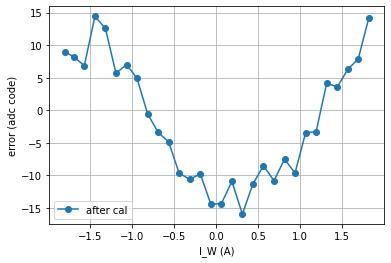

In [245]:
I_dvm = V_meas/R_W.R_ohms
error_A = I_dvm - I_meas
error_c = error_A/CurrMon.default_slope
#plt.plot(I_dvm, uncal_error_c, 'o-', label='default cal')
plt.plot(I_dvm, error_c, 'o-', label='after cal')
plt.legend()
plt.xlabel('I_W (A)')
plt.ylabel('error (adc code)')
plt.grid('both')

In [246]:
rms(error_c)

9.339859654229667

### TODO: What is a tolerable amount of error in the verification step?

Can compare the measured rms error to the expected rms error from the ShowCalibration() step

# Calibrate VOLT_MON

Place DVM voltage probes at:  
V+ @ VMotorMid (TP306)  
V- @ R314-1 (TP311)

In [247]:
VoltMon = AdcChannel(2, adcBits = 16, differential=True, target_units='V')

In [248]:
testCodes = np.linspace(0, 4095, 20, dtype=int)

In [249]:
serialCmd(sr542, '$IEN ON')
v_dvm, c_adc = VoltMon.MeasCodeVs(CurrU, testCodes)
serialCmd(sr542, '$SUV 2048, 2048')
serialCmd(sr542, '$IEN OFF')

Progress: [####################] 100.0%


RMS Residual Error = 1.075e-03 adc codes


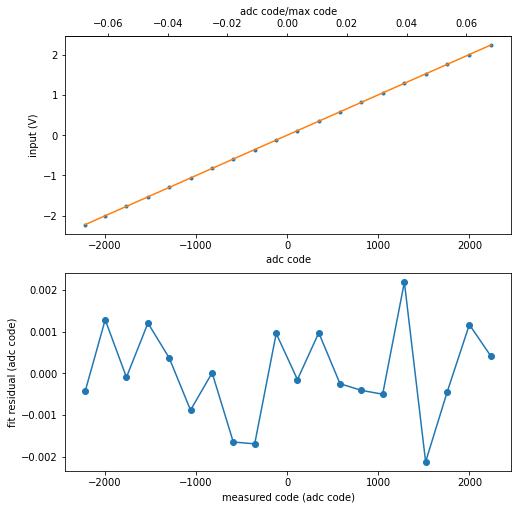

In [250]:
VoltMon.CalculateCal(v_dvm, c_adc)

In [251]:
print(VoltMon.calSlope)
print(VoltMon.calOffset)

0.001004995906384326
0.0025157255393646427


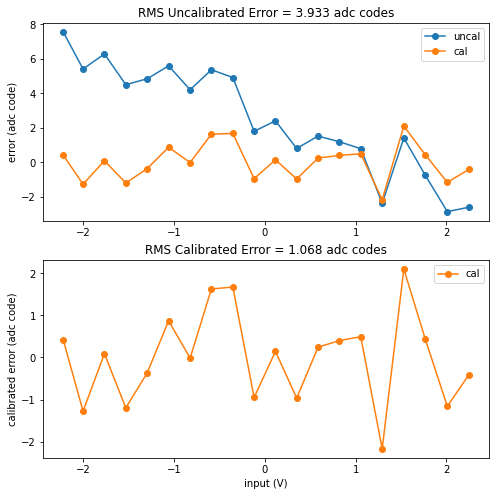

In [252]:
VoltMon.ShowCalibration(v_dvm, c_adc)

In [253]:
VoltMon.UploadCalData()
VoltMon.SaveCalData()

Quantity  Default cal    On-unit cal    New cal        (New - On-unit)
----------------------------------------------------------------------
slope     1.007111e-03   1.004775e-03   1.004996e-03   2.209064e-07   
offset    0.000000e+00   2.543645e-03   2.515726e-03   -2.791946e-05  
This will adjust the calibration of this ADC channel


## Verify VOLT_MON

In [254]:
serialQry(sr542, '$ADC? 2')

'2.515726e-03, 1.004996e-03'

In [255]:
verifyCodes = np.linspace(0, 4095, 30, dtype=int)

In [256]:
serialCmd(sr542, '$IEN ON')
V_mon = []
V_dvm = []
for s in verifyCodes:
    CurrU(s)

    time.sleep(0.5) #TODO: how long to sleep here?    
    V_mon.append(float(serialQry(sr542, 'VOLT? INST')))
    # TODO: choose range properly
    V_dvm.append(float(dvm.query('MEAS:VOLT:DC? AUTO, 3e-5').strip('\n')))   

    update_progress(len(V_mon) / len(verifyCodes))

V_mon = np.array(V_mon)
V_dvm = np.array(V_dvm)

serialCmd(sr542, '$SUV 2048, 2048')
serialCmd(sr542, '$IEN OFF')

Progress: [####################] 100.0%


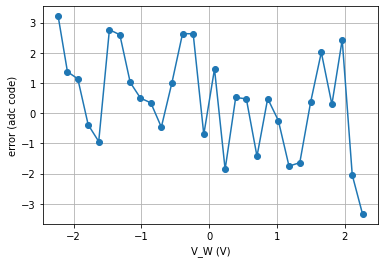

In [257]:
error_V = V_dvm - V_mon
error_c = error_V/VoltMon.default_slope
plt.plot(V_dvm, error_c, 'o-')
plt.xlabel('V_W (V)')
plt.ylabel('error (adc code)')
plt.grid('both')

In [258]:
rms(error_c)

1.6898966252222454

# Calibrate CHOP_5V_MON

In [19]:
Chop5vMon = AdcChannel(4, adcBits = 12, differential=False, target_units='V')

In [20]:
Chop5vMon.default_offset

2.45

In [21]:
def RepeatMeasurement(query, num, dt_s):
    results = []
    for i in range(num):
        result = int(serialQry(sr542, query))
        results.append(result)
        time.sleep(dt_s)

    return results

In [22]:
def WaitForPhaseLock():
    t0 = time.time()
    while True:
        time.sleep(0.5)            
        chcr = serialQry(sr542, 'CHCR?')         
        if((int(chcr) & 8)):
            break    

    print(f'Time to phase lock = {time.time() - t0:.3f} seconds')

In [23]:
serialCmd(sr542, 'MOTR ON')
WaitForPhaseLock()

KeyboardInterrupt: 

In [41]:
serialCmd(sr542, 'MOTR OFF')

In [24]:
def EstablishDisconnectThresh():
    if yes_or_no("Please *connect* Chopper Head. Is Chopper Head connected?"):
        # Set up Chopper to Run at a particular frequency
        serialCmd(sr542, 'SRCE INT')
        serialCmd(sr542, 'IFRQ 50.0')
        serialCmd(sr542, 'CTRL SHAFT')
        serialCmd(sr542, 'MOTR ON')

        WaitForPhaseLock()
        
        # Collect statistics on the CHOP_5V_MON ADC code
        conn_codes = RepeatMeasurement('$COD? 4', 30, 0.5)

        serialCmd(sr542, 'MOTR OFF')
    else:
        print('Test aborted')
        return

    if yes_or_no("Please *disconnect* Chopper Head. Is Chopper Head disconnected?"):
        serialCmd(sr542, '$CEN ON')
        time.sleep(0.5)
        disconn_codes = RepeatMeasurement('$COD? 4', 30, 0.5)
        serialCmd(sr542, '$CEN OFF')
    else:
        print('Test aborted')
        return

    conn_volts = Chop5vMon.CodeToVolts(np.array(conn_codes))
    disconn_volts = Chop5vMon.CodeToVolts(np.array(disconn_codes))

    max_conn = np.max(conn_volts)
    min_disconn = np.min(disconn_volts)

    thresh_v = np.mean([max_conn, min_disconn])

    # TODO: Check margins:
    dist_from_on = thresh_v - max_conn
    dist_from_off = min_disconn - thresh_v

    print(f'Threshold Voltage = {thresh_v:.6f} V')
    print(f'which is {dist_from_on:.6f} V ({Chop5vMon.VoltsToCode(dist_from_on):.0f} codes) from ON & CONNECTED')
    print(f'and {dist_from_off:.6f} V ({Chop5vMon.VoltsToCode(dist_from_off):.0f} codes) from ON & DISCONNECTED')

    fig, ax = plt.subplots(figsize = (8,8))
    conn_hist = ax.hist(conn_volts, label='connected, running')
    disconn_hist = ax.hist(disconn_volts, label='disconnected')
    ymax = np.max([np.max(conn_hist[0]), np.max(disconn_hist[0])])
    ax.vlines(thresh_v, 0, ymax, color='black', linestyles='dashed', label='DISCONN_THRESH_V')
    ax.legend()
    ax.set_xlabel('CHOP_5V_MON voltage (V)')
    ax.set_ylabel('counts')
    ax.set_title('Histogram of CHOP_5V_MON Measurements')

    Chop5vMon.calOffset = thresh_v
        
    return thresh_v

Time to phase lock = 11.875 seconds
Threshold Voltage = 2.461099 V
which is 0.038681 V (48 codes) from ON & CONNECTED
and 0.038681 V (48 codes) from ON & DISCONNECTED


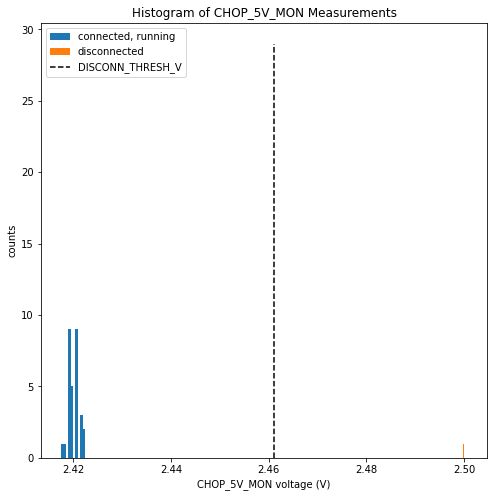

In [25]:
thresh_v = EstablishDisconnectThresh()

In [26]:
Chop5vMon.calOffset = thresh_v

In [27]:
Chop5vMon.UploadCalData()

Quantity  Default cal    On-unit cal    New cal        (New - On-unit)
----------------------------------------------------------------------
slope     1.000000e+00   1.000000e+00   1.000000e+00   0.000000e+00   
offset    2.450000e+00   2.460696e+00   2.461099e+00   4.029011e-04   
This will adjust the calibration of this ADC channel


In [28]:
Chop5vMon.SaveCalData()